In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-2_39880.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-1_8360.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-1_45060.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-2_1190.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-1_22920.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-2_1440.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0313-2_9360.jpg
/kaggle/input/tusimple-preprocessed-dataset/training/kaggle/working/tusimple_preprocessed/training/lane-masks/0601_

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Define U-Net architecture
def create_unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(512, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(512, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(32, 3, activation='sigmoid', padding='same')(pool3)
    conv4 = Conv2D(32, 3, activation='sigmoid', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Load and preprocess the dataset
def load_and_preprocess_dataset(data_dir, img_height, img_width):
    X = []
    y = []
    frames_dir = os.path.join(data_dir, 'frames')
    masks_dir = os.path.join(data_dir, 'lane-masks')
    for frame_file in os.listdir(frames_dir):
        if frame_file.endswith('.jpg'):
            frame_path = os.path.join(frames_dir, frame_file)
            mask_file = frame_file
            mask_path = os.path.join(masks_dir, mask_file)
            if os.path.exists(mask_path):
                img = load_img(frame_path, target_size=(img_height, img_width))
                img_array = img_to_array(img) / 255.0
                X.append(img_array)
                mask_img = load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
                mask_array = img_to_array(mask_img) / 255.0
                y.append(mask_array)
    return np.array(X), np.array(y)

# Define model input shape based on your dataset
img_height = 128
img_width = 128
num_channels = 3  # Assuming RGB images

# Define dataset directory
dataset_dir = '/kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training'

# Load and preprocess the dataset
X, y = load_and_preprocess_dataset(dataset_dir, img_height, img_width)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create an instance of the U-Net model
model = create_unet_model((img_height, img_width, num_channels))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=1, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

2024-04-16 09:41:35.093625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 09:41:35.093733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 09:41:35.207460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/5
   1/3263 ━━━━━━━━━━━━━━━━━━━━ 36:58:54 41s/step - accuracy: 0.9276 - loss: 0.6875

I0000 00:00:1713260628.542139      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3263/3263 ━━━━━━━━━━━━━━━━━━━━ 337s 91ms/step - accuracy: 0.9532 - loss: 0.1203 - val_accuracy: 0.9633 - val_loss: 0.0602
Epoch 2/5
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 295s 90ms/step - accuracy: 0.9632 - loss: 0.0593 - val_accuracy: 0.9648 - val_loss: 0.0543
Epoch 3/5
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 293s 90ms/step - accuracy: 0.9652 - loss: 0.0522 - val_accuracy: 0.9659 - val_loss: 0.0498
Epoch 4/5
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 292s 90ms/step - accuracy: 0.9663 - loss: 0.0488 - val_accuracy: 0.9661 - val_loss: 0.0499
Epoch 5/5
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 292s 89ms/step - accuracy: 0.9667 - loss: 0.0473 - val_accuracy: 0.9659 - val_loss: 0.0496


2024-04-16 10:08:23.652859: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,512,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,128,128]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-16 10:08:23.919879: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.267170202s
Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,512,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,128,128]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9660 - loss: 0.0497

2024-04-16 10:11:18.352757: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[11,512,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,512,128,128]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-16 10:11:18.741392: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.388730573s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[11,512,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,512,128,128]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_al

12/12 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.9660 - loss: 0.0498
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 663ms/step


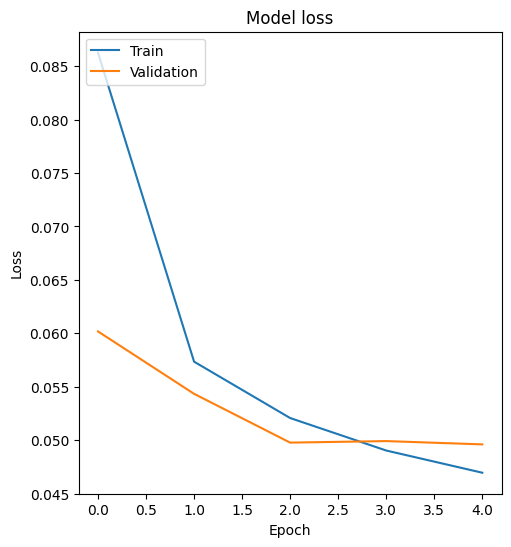

In [3]:
# Plot training & validation loss values

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

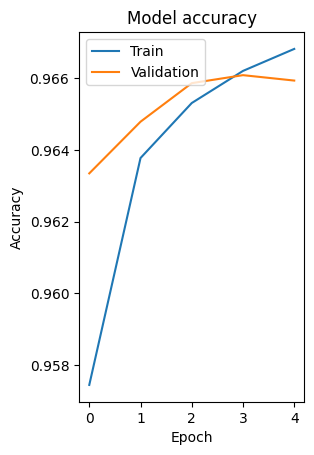

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()